In [1]:
%matplotlib inline

## Imports

In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import dask.dataframe as dd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

## Load the data file
**Note: A small amount of pre-processing was done on the original file, as follows.**
* (1) Flatten GWAS columns (see `flattener.py`), since multiple entries exist separated by `|`.
* (2) Filter for `gwas_source = 'GWAS Catalog`, since only these records of interest.
Result:
```
postgap.20170825.txt.gz -> postgap.20170825.gwas.flat.txt.gz
```

The command line calls for (2) are:
```
gzcat postgap.20170825.flat.txt.gz | head -n1 | gzip > postgap.20170825.gwas.flat.txt.gz
gzcat postgap.20170825.flat.txt.gz | grep 'GWAS Catalog' | gzip >> postgap.20170825.gwas.flat.txt.gz
```

In [3]:
pg = pd.read_csv('postgap.20171113.filtered.txt.gz', sep='\t', na_values=['None'])
print(pg.shape)
pg.head()

/Users/gpeat/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (10,27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(31224438, 38)


,ld_snp_rsID,chrom,pos,afr_maf,amr_maf,eas_maf,eur_maf,sas_maf,gene_symbol,gene_id,...,vep_sum,vep_mean,GTEx,VEP,Fantom5,DHS,PCHiC,Nearest,Regulome,VEP_reg
0,rs10740053,10,63702584,0.7784,0.5317,0.6736,0.6928,0.4888,CISD1,ENSG00000122873,...,0.0,0.0,0.0,0.0,0.0,0.0,0.009814,0.0,0.0,0
1,rs10740054,10,63702586,0.7784,0.5317,0.6736,0.6928,0.4877,IPMK,ENSG00000151151,...,0.0,0.0,0.0,0.0,0.0,0.0,0.009814,0.0,0.0,0
2,rs10740053,10,63702584,0.7784,0.5317,0.6736,0.6928,0.4888,IPMK,ENSG00000151151,...,0.0,0.0,0.0,0.0,0.0,0.0,0.009814,0.0,0.0,0
3,rs4506592,10,63727187,0.7020,0.5101,0.6538,0.6511,0.4785,IPMK,ENSG00000151151,...,0.0,0.0,0.0,0.0,0.0,0.0,0.008807,0.0,0.0,0
4,rs11332367,10,63736618,0.8396,0.5303,0.6448,0.6700,0.4826,RTKN2,ENSG00000182010,...,0.0,0.0,0.0,0.0,0.0,0.0,0.007876,0.0,0.0,0


## Datamodel
POSTGAP data has many columns of data, but the unique key is `(ld_snp_rsID, gwas_snp, gene_id, disease_efo_id, gwas_pmid)`.

**Question**: Is this combination indeed unique?

In [4]:
primary_key = ['ld_snp_rsID', 'gwas_snp', 'gene_id', 'disease_efo_id', 'gwas_pmid']
primary_key_groups = pg.groupby(primary_key)
primary_key_group_sizes = primary_key_groups.size()
primary_key_groups_non_unique = primary_key_group_sizes[primary_key_group_sizes > 1]
# if the primary_key is unique, then primary_key_groups_non_unique should be empty
print(primary_key_groups_non_unique.shape)
primary_key_groups_non_unique.sort_values(ascending=False).head()

(2991433,)


ld_snp_rsID  gwas_snp   gene_id          disease_efo_id  gwas_pmid   
rs10241659   rs1055144  ENSG00000086300  EFO_0008002     PMID28448500    25
rs10238703   rs1055144  ENSG00000078399  EFO_0008002     PMID28448500    25
                        ENSG00000086300  EFO_0008002     PMID28448500    25
rs41469349   rs1055144  ENSG00000257184  EFO_0008002     PMID28448500    25
rs4722529    rs1055144  ENSG00000222004  EFO_0008002     PMID28448500    25
dtype: int64

**Question**: How many unique `primary keys` (as defined above) are there?

In [5]:
print(primary_key_group_sizes.shape)

(25742148,)


**Question**: How many unique `(ld_snp_rsID, gene_id, disease_efo_id, gwas_pmid)` sets are there? (ie. `primary key` above without `gwas_snp`)?

In [6]:
other_key = ['ld_snp_rsID', 'gene_id', 'disease_efo_id', 'gwas_pmid']
other_key_groups = pg.groupby(other_key)
other_key_group_sizes = other_key_groups.size()
print(other_key_group_sizes.shape)

(22639500,)


**Question**: How many unique `(gwas_snp, gene_id, disease_efo_id, gwas_pmid)` sets are there? (ie. `primary key` above without `ld_snp_rsID`)?

In [7]:
other_key = ['gwas_snp', 'gene_id', 'disease_efo_id', 'gwas_pmid']
other_key_groups = pg.groupby(other_key)
other_key_group_sizes = other_key_groups.size()
print(other_key_group_sizes.shape)

(831679,)


**Question**: How many unique `(gwas_snp, disease_efo_id, gwas_pmid)` sets are there?

In [8]:
key = ['gwas_snp', 'disease_efo_id', 'gwas_pmid']
key_groups = pg.groupby(key)
key_group_sizes = key_groups.size()
print(key_group_sizes.shape)

(45997,)


**Question**: Is the POSTGAP score unique by the primary key described above?

In [55]:
score_counts_per_primary_key_group = primary_key_groups['score'].nunique()
print(score_counts_per_primary_key_group[score_counts_per_primary_key_group > 1])

ld_snp_rsID  gwas_snp    gene_id          disease_efo_id  gwas_pmid   
rs7086284    rs10559647  ENSG00000150076  EFO_0007984     PMID27863252    2
rs7086385    rs10559647  ENSG00000150076  EFO_0007984     PMID27863252    2
Name: score, dtype: int64


**Question**: What is the distribution of target counts per `('gwas_snp', 'disease_efo_id', 'gwas_pmid')` set?

In [12]:
target_counts_for_key_groups = key_groups['gene_id'].nunique()

In [26]:
target_counts = target_counts_for_key_groups.reset_index(level=['gwas_snp', 'disease_efo_id', 'gwas_pmid']).rename(columns={'gene_id': 'target_count_per_key'})
target_counts.head()

,gwas_snp,disease_efo_id,gwas_pmid,target_count_per_key
0,rs1000005,EFO_0004842,PMID27863252,22
1,rs1000005,EFO_0007991,PMID27863252,22
2,rs1000083,EFO_0006951,PMID28039263,9
3,rs1000083,GO_0072718,PMID28039263,9
4,rs1000113,EFO_0000384,PMID17554300,28


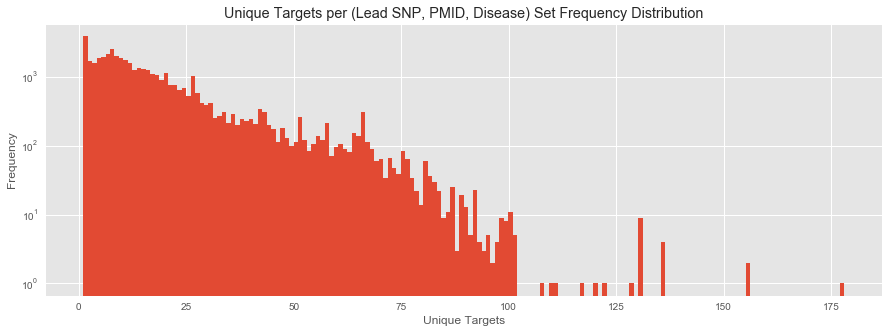

In [27]:
plt.figure(figsize=(15, 5))
plt.hist(target_counts_for_key_groups, bins=170, log=True)
plt.title('Unique Targets per (Lead SNP, PMID, Disease) Set Frequency Distribution')
plt.xlabel('Unique Targets')
plt.ylabel('Frequency')
plt.show()

**Question**: What is the distribution of POSTGAP scores per `('ld_snp_rsID', 'gwas_snp', 'gene_id', 'disease_efo_id', 'gwas_pmid')` set?

In [28]:
scores_per_primary_key_group = primary_key_groups['score'].first() # ignore exceptions to uniqueness found above

In [29]:
scores = scores_per_primary_key_group.reset_index(level=['gwas_snp', 'disease_efo_id', 'gwas_pmid', 'ld_snp_rsID', 'gene_id'])
scores.head()

,ld_snp_rsID,gwas_snp,gene_id,disease_efo_id,gwas_pmid,score
0,esv3585200,rs10492972,ENSG00000130939,EFO_0003885,PMID18997785,0.0
1,esv3585200,rs10492972,ENSG00000175279,EFO_0003885,PMID18997785,0.0
2,esv3585200,rs10492972,ENSG00000251503,EFO_0003885,PMID18997785,0.0
3,esv3585200,rs17401966,ENSG00000130939,EFO_0000182,PMID20676096,0.0
4,esv3585200,rs17401966,ENSG00000175279,EFO_0000182,PMID20676096,0.0


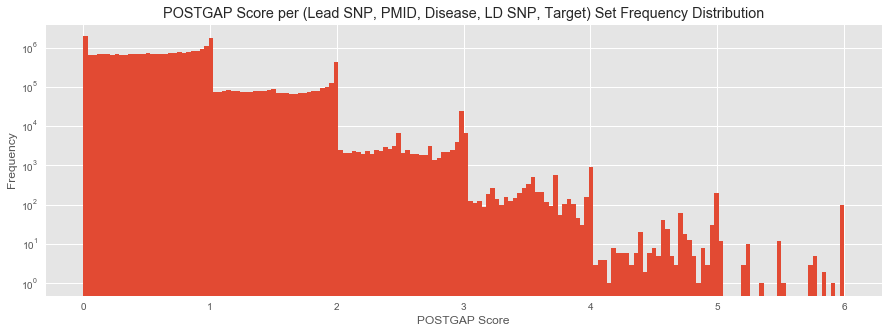

In [30]:
primary_key_groups['score']
plt.figure(figsize=(15, 5))
plt.hist(scores_per_primary_key_group, bins=170, log=True)
plt.title('POSTGAP Score per (Lead SNP, PMID, Disease, LD SNP, Target) Set Frequency Distribution')
plt.xlabel('POSTGAP Score')
plt.ylabel('Frequency')
plt.show()

**Question**: What is the combined distribution of the above two distributions?

In [44]:
combi_dist = pd.merge(target_counts, scores, on=('gwas_snp', 'disease_efo_id', 'gwas_pmid'))
combi_dist.head()

,gwas_snp,disease_efo_id,gwas_pmid,target_count_per_key,ld_snp_rsID,gene_id,score
0,rs1000005,EFO_0004842,PMID27863252,22,rs1000005,ENSG00000142166,1.885208
1,rs1000005,EFO_0004842,PMID27863252,22,rs1000005,ENSG00000142188,1.115687
2,rs1000005,EFO_0004842,PMID27863252,22,rs1000005,ENSG00000142207,1.578838
3,rs1000005,EFO_0004842,PMID27863252,22,rs1000005,ENSG00000159055,1.964344
4,rs1000005,EFO_0004842,PMID27863252,22,rs1000005,ENSG00000159082,1.807707


In [45]:
combi_dist['score'] = combi_dist['score'].apply(lambda x: np.floor(x * 10) / 10)

In [46]:
grid = pd.crosstab(combi_dist['score'], combi_dist['target_count_per_key'])
grid.head()

target_count_per_key,1,2,3,4,5,6,7,8,9,10,...,110,111,117,120,122,129,131,136,156,178
score,,,,,,,,,,,,,,,,,,,,,
0.0,59439,32931,27191,29323,33250,44512,60461,90802,58609,46751,...,1124,1775,537,582,177,1430,6915,1728,220,2017
0.1,2130,4456,8739,11135,14717,19728,29600,48526,31239,30321,...,98,456,122,285,32,108,2158,268,228,430
0.2,2111,5155,8862,13273,14963,20656,28741,44959,36280,31479,...,92,356,105,276,33,97,2617,276,314,470
0.3,1901,4764,9219,12573,16866,20992,30743,51473,31834,31797,...,111,422,125,281,37,85,1970,232,250,391
0.4,1925,4581,8399,13439,16682,21810,30403,56997,30265,32865,...,102,614,148,249,24,90,2159,296,164,427


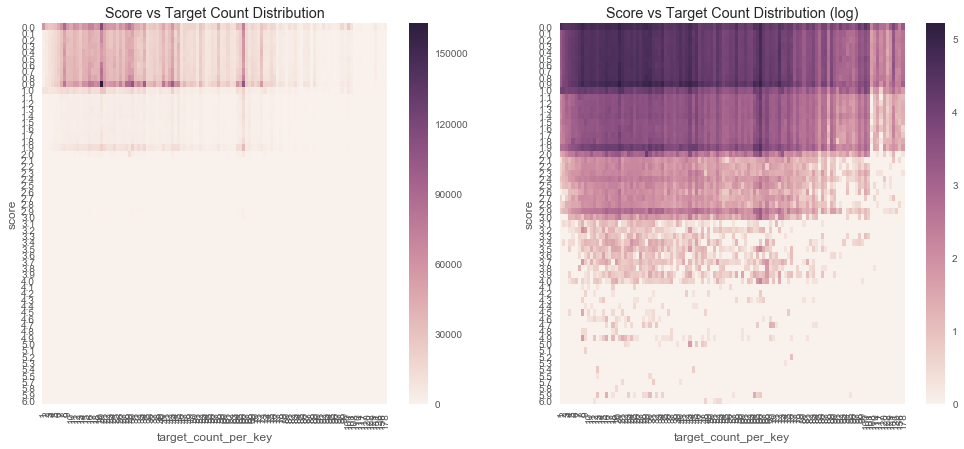

In [57]:
plt.figure(figsize=(17, 7))
plt.subplot(1, 2, 1)
sns.heatmap(grid)
plt.title('Score vs Target Count Distribution')

plt.subplot(1, 2, 2)
sns.heatmap(grid.apply(lambda x: np.log10(x + 1)))
plt.title('Score vs Target Count Distribution (log)')
plt.show()

**Question**: How many unique `ld_snp_rsID` values are there? How about the other elements of the unique key?

In [12]:
print('Genes: {}'.format(pg['gene_id'].nunique()))
print('LD SNPs: {}'.format(pg['ld_snp_rsID'].nunique()))
print('GWAS SNPs: {}'.format(pg['gwas_snp'].nunique()))
print('Diseases: {}'.format(pg['disease_efo_id'].nunique()))
print('GWAS PubMed IDs: {}'.format(pg['gwas_pmid'].nunique()))

Genes: 18651
LD SNPs: 673473
GWAS SNPs: 28470
Diseases: 1740
GWAS PubMed IDs: 2513


**Question**: How frequently does each unique `ld_snp_rsID` appear across all rows? How about the other elements of the unique key?

ld_snp_rsID
rs174562    17529
rs174574    17504
rs1535      17385
rs174564    17247
rs174554    17241
dtype: int64
gwas_snp
rs174547      180140
rs6772896     136192
rs16957304    103614
rs102275      100287
rs1879586      94494
dtype: int64
gene_id
ENSG00000169684    58605
ENSG00000140395    58529
ENSG00000136378    58329
ENSG00000136381    57976
ENSG00000188266    57975
dtype: int64
disease_efo_id
EFO_0008002    1106784
EFO_0007789     764444
EFO_0007986     597263
GO_0097366      582423
EFO_0004318     561479
dtype: int64
gwas_pmid
PMID27863252    3518038
PMID28448500    1727850
PMID26634245    1258386
PMID28443625     937092
PMID25673412     618139
dtype: int64


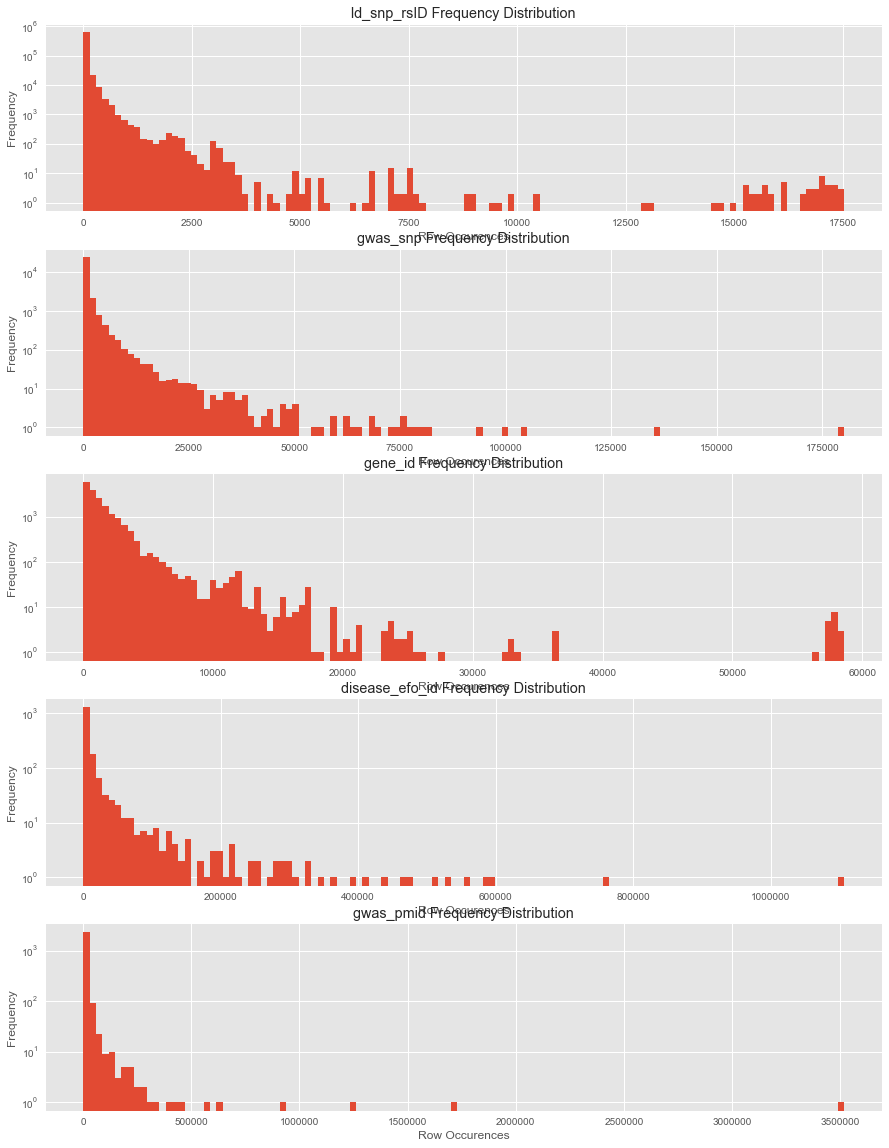

In [13]:
plt.figure(figsize=(15, 20))

for (i, c) in enumerate(primary_key):
    groups = pg.groupby(c)
    group_frequencies = groups.size()

    plt.subplot(5, 1, i + 1)
    plt.hist(group_frequencies, bins=120, log=True)
    plt.title('{} Frequency Distribution'.format(c))
    plt.xlabel('Row Occurences')
    plt.ylabel('Frequency')
    
    print(group_frequencies.sort_values(ascending=False).head())

plt.show()

**Question**: How many unique `(ld_snp_rsID, gwas_snp)` pairs are there? How about other pairwise combinations of the unique key (there are 5C2=10 of them)?

In [14]:
import itertools

pairs = itertools.combinations(primary_key, 2)
for (i, c) in enumerate(pairs):
    print('{} unique pairs: {}'.format(c, len(pg.groupby(c).size())))

('ld_snp_rsID', 'gwas_snp') unique pairs: 1132009
('ld_snp_rsID', 'gene_id') unique pairs: 8226315
('ld_snp_rsID', 'disease_efo_id') unique pairs: 1316189
('ld_snp_rsID', 'gwas_pmid') unique pairs: 1127657
('gwas_snp', 'gene_id') unique pairs: 482395
('gwas_snp', 'disease_efo_id') unique pairs: 42941
('gwas_snp', 'gwas_pmid') unique pairs: 33534
('gene_id', 'disease_efo_id') unique pairs: 516009
('gene_id', 'gwas_pmid') unique pairs: 435480
('disease_efo_id', 'gwas_pmid') unique pairs: 4470


**Question**: How frequestly does each `(ld_snp_rsID, gwas_snp)` pair occur across all rows? How about other pairwise combinations of the unique key (there are 5C2=10 of them)?

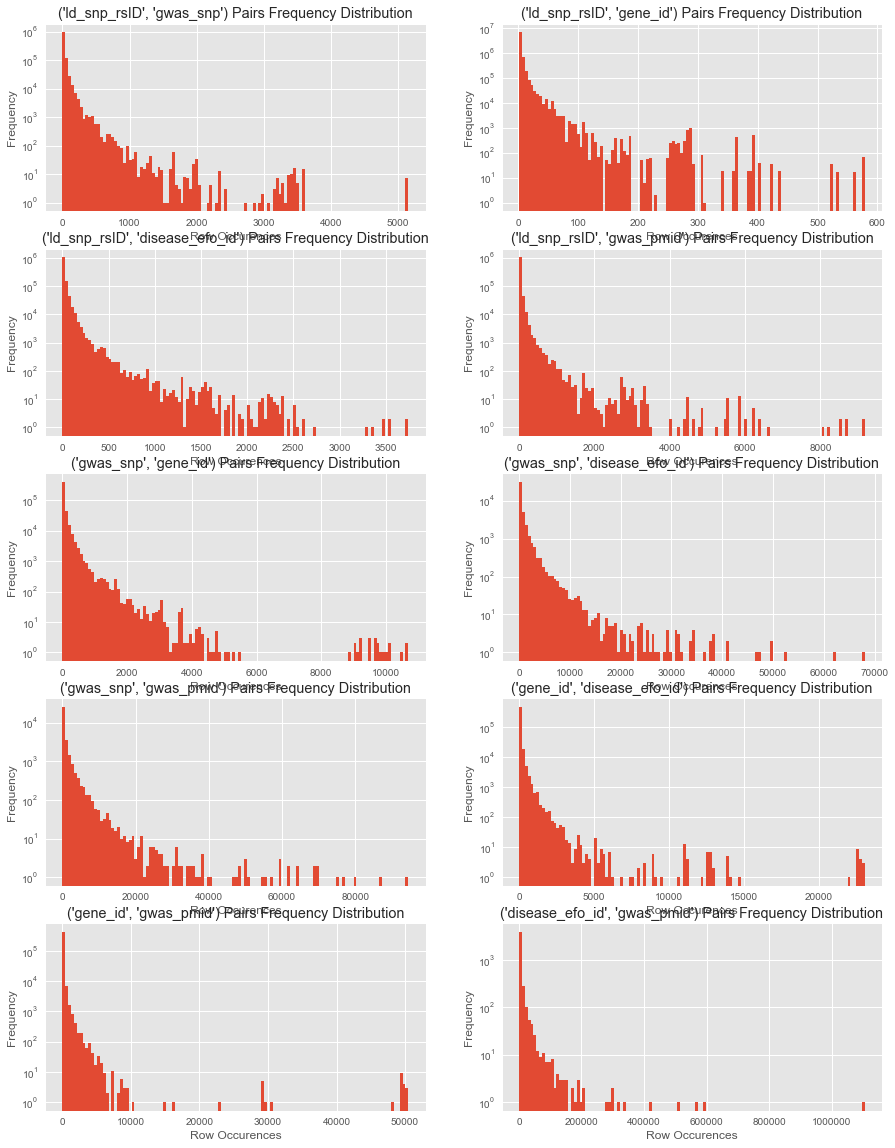

In [15]:
plt.figure(figsize=(15, 20))

pairs = itertools.combinations(primary_key, 2)
for (i, c) in enumerate(pairs):
    connections = pg.groupby(c)
    connection_frequencies = connections.size()

    plt.subplot(5, 2, i + 1)
    plt.hist(connection_frequencies, bins=120, log=True)
    plt.title('{} Pairs Frequency Distribution'.format(c))
    plt.xlabel('Row Occurences')
    plt.ylabel('Frequency')

plt.show()

### Score, r2 and GWAS p-value
Of the above pairs, three have an associated strength, as below.

| Strength measure | Pair | Range |
| -- | -- | -- |
| score | ('ld_snp_rsID', 'gene_id') | [0, 38] |
| r2 | ('ld_snp_rsID', 'gwas_snp') | [0.7, 1.0] |
| gwas_pvalue | ('gwas_snp', 'disease_efo_id') | [0, 1] |

The distribution can be given across all rows *OR* across all unique pairs (as in the table). Both are displayed below, for each strength measure.

**Question**: How is the POSTGAP score distributed?

In [16]:
def plot_strength_distribution(connection_strength_all, connection_strength_no_dupes, label):
    plt.figure(figsize=(15, 5))

    plt.subplot(121)
    plt.hist(connection_strength_all.values.flatten(), bins=100, log=True)
    plt.title('{} Distribution'.format(label))
    plt.ylabel('Frequency')
    plt.xlabel('Value')

    plt.subplot(122)
    plt.hist(connection_strength_no_dupes.values.flatten(), bins=100, log=True)
    plt.title('{} Distribution (no duplicate pairs)'.format(label))
    plt.ylabel('Frequency')
    plt.xlabel('Value')
    plt.show()

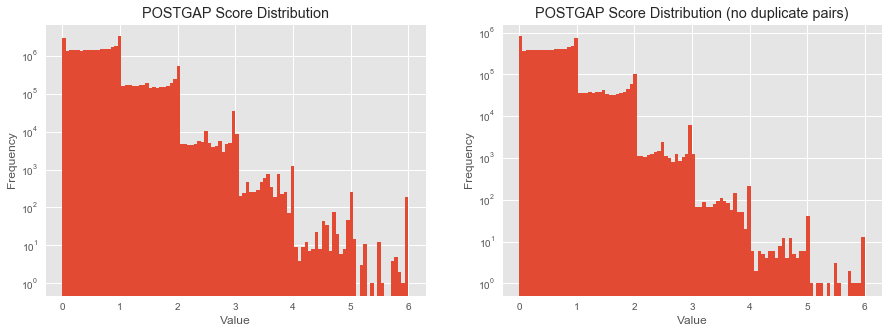

In [17]:
score_all = pg['score']
# TODO: Check score is the same across all (gene_id, ld_snp_rsID) pairs (to justify use of first())
score_no_dupes = pg.groupby(['gene_id', 'ld_snp_rsID'])['score'].first()
plot_strength_distribution(score_all, score_no_dupes, 'POSTGAP Score')

**Question**: How is the `r2` value distributed?

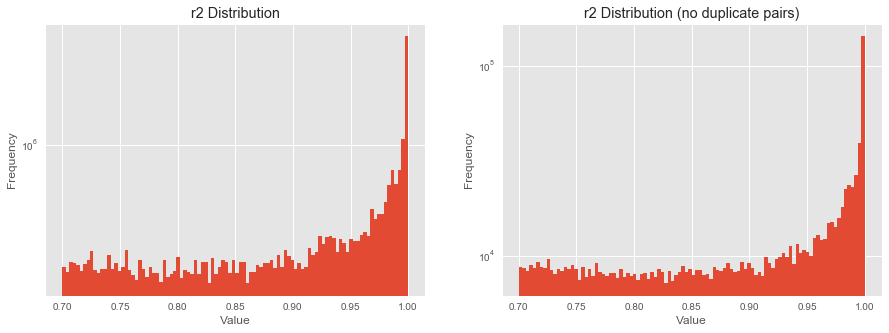

In [18]:
r2_all = pg['r2']
r2_no_dupes = pg.groupby(['ld_snp_rsID', 'gwas_snp'])['r2'].first()
plot_strength_distribution(r2_all, r2_no_dupes, 'r2')
# note: r2 col appears to contain r, not r2

In [19]:
pg[pg.r2 < 0].head()

,ld_snp_rsID,chrom,pos,afr_maf,amr_maf,eas_maf,eur_maf,sas_maf,gene_symbol,gene_id,...,vep_sum,vep_mean,GTEx,VEP,Fantom5,DHS,PCHiC,Nearest,Regulome,VEP_reg


**Question**: How is the `gwas_pvalue` distributed?

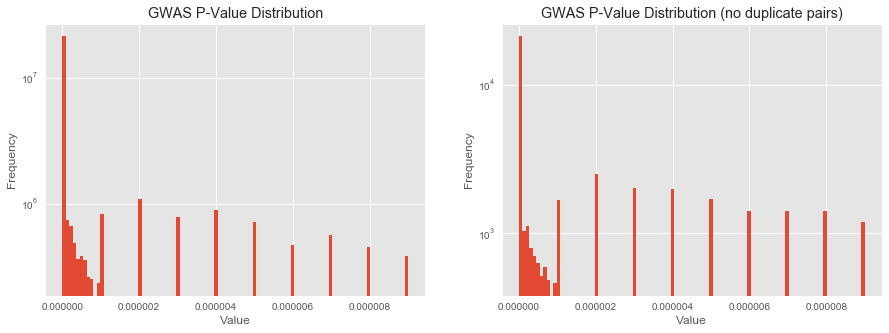

In [20]:
pval_all = pg['gwas_pvalue']
# TODO: check if the grouping should include pmid for uniqueness of first()
pval_no_dupes = pg.groupby(['gwas_snp', 'disease_efo_id'])['gwas_pvalue'].first()
plot_strength_distribution(pval_all, pval_no_dupes, 'GWAS P-Value')

## Connection degree distribution
One key aspect of the POSTGAP data model is the clusters of `ld_snp`s per `lead_snp`. We could ask the following questions:

**Question**: If a given `ld_snp` is chosen, how many unique `lead_snp`s is it linked to?

**Question**: If a given `lead_snp` is chosen, how many unique `ld_snp`s is it linked to?

In [21]:
def plot_connection_degree_distribution(a_degrees, b_degrees, a_label, b_label):
    plt.figure(figsize=(15, 5))

    plt.subplot(121)
    plt.hist(a_degrees.values.flatten(), bins=100, log=True)
    plt.title('{}s per {} Distribution'.format(b_label, a_label))
    plt.ylabel('Frequency')
    plt.xlabel('Degree')

    plt.subplot(122)
    plt.hist(b_degrees.values.flatten(), bins=100, log=True)
    plt.title('{}s per {} Distribution'.format(a_label, b_label))
    plt.ylabel('Frequency')
    plt.xlabel('Degree')
    plt.show()

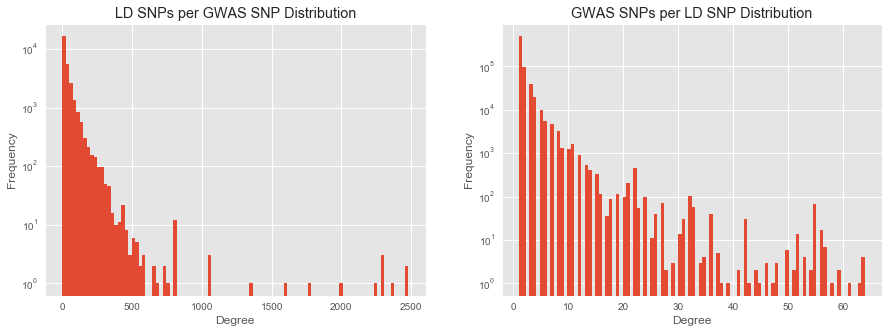

In [22]:
# Note: use count() to include row repeats, or nunique() to skip repeats
ld_snps_per_lead_snp = pg.groupby('gwas_snp')['ld_snp_rsID'].nunique()
lead_snps_per_ld_snp = pg.groupby('ld_snp_rsID')['gwas_snp'].nunique()
plot_connection_degree_distribution(ld_snps_per_lead_snp, lead_snps_per_ld_snp, 'GWAS SNP', 'LD SNP')

Similarly:
    
**Question**: If a given `gene` is chosen, how many `ld_snp`s is it linked to?
    
**Question**: If a given `ld_snp` is chosen, how many `gene`s is it linked to?

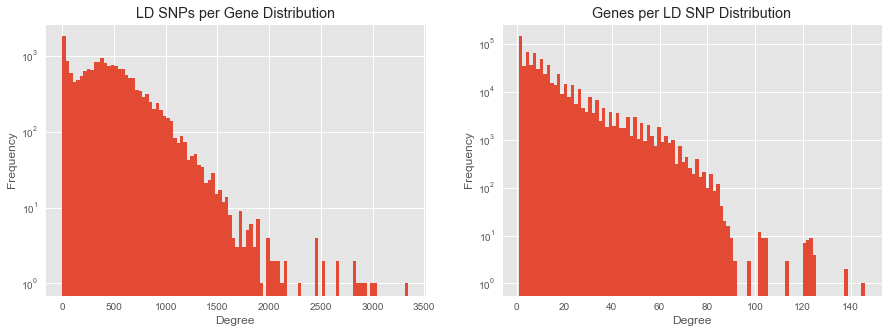

In [23]:
ld_snps_per_gene = pg.groupby('gene_id')['ld_snp_rsID'].nunique()
genes_per_ld_snp = pg.groupby('ld_snp_rsID')['gene_id'].nunique()
plot_connection_degree_distribution(ld_snps_per_gene, genes_per_ld_snp, 'Gene', 'LD SNP')

Similarly:

**Question**: If a given `lead_snp` is chosen, how many `disease`s is it linked to?

**Question**: If a given `disease` is chosen, how many `lead_snp`s is it linked to?

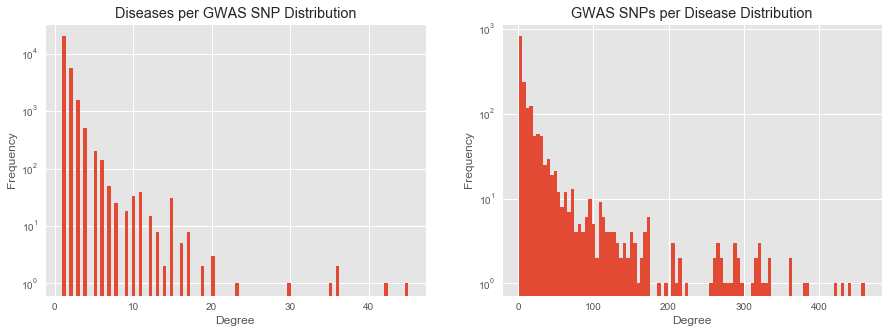

In [24]:
diseases_per_lead_snp = pg.groupby('gwas_snp')['disease_efo_id'].nunique()
lead_snps_per_disease = pg.groupby('disease_efo_id')['gwas_snp'].nunique()
plot_connection_degree_distribution(diseases_per_lead_snp, lead_snps_per_disease, 'GWAS SNP', 'Disease')

## Clusters and their windows
From the perspective of the planned visualisation, clusters of `ld_snp`s might be indexed by:
* A: `gwas_snp` (ie. lumping all genes/diseases in; perhaps not as useful, **but** original test slices of this format)
* B: `gwas_snp, gene_id` (ie. lumping all diseases in; perhaps useful on target profile page)
* C: `gwas_snp, disease_efo_id` (ie. lumping all genes in; perhaps useful on disease profile page)
* D: `gwas_snp, gene_id, disease_efo_id` (ie. as specific as possible; perhaps useful on the evidence page)

**Question**: Under each cluster indexing scheme, how many unique `ld_snp`s are there per cluster? 

**Question**: Under each cluster indexing scheme, what is the base pair window size of the `ld_snp`s? 

In [25]:
set_a = ['gwas_snp']
set_b = ['gwas_snp', 'gene_id']
set_c = ['gwas_snp', 'disease_efo_id']
set_d = ['gwas_snp', 'gene_id', 'disease_efo_id']

In [26]:
def plot_cluster_scheme_summary(key_set):
    clusters = pg[[*key_set, 'ld_snp_rsID', 'pos', 'chrom']].drop_duplicates().groupby(key_set)
    cluster_sizes = clusters['ld_snp_rsID'].nunique() # again the nunique/count distinction
    
    sorted_sizes = cluster_sizes.sort_values().values
    smallest = sorted_sizes[0]
    largest = sorted_sizes[-1]
    
    cluster_windows = clusters['pos'].agg([np.min, np.max])
    
    # TODO: currently cluster_window_sizes contains dupes (by ld_snp_rsID) that cluster_sizes removes with nunique()
    #       how to remove?
    cluster_window_sizes = cluster_windows.T.apply(lambda x: x['amax'] - x['amin'])
    sorted_window_sizes = cluster_window_sizes.sort_values().values
    narrowest = sorted_window_sizes[0]
    widest = sorted_window_sizes[-1]
    
    print('Clustering by {}'.format(key_set))
    print('Number of clusters: {}'.format(len(cluster_sizes)))
    print('Smallest {};  Largest {}'.format(smallest, largest))
    print('Narrowest {};  Widest {}'.format(narrowest, widest))
    
    plt.figure(figsize=(15, 5))

    plt.subplot(121)
    plt.hist(cluster_sizes, bins=50, log=True)
    plt.title('Cluster Size Distribution\n(by {})'.format(key_set))
    plt.ylabel('Frequency')
    plt.xlabel('Size')

    plt.subplot(122)
    plt.hist(cluster_window_sizes, bins=50, log=True)
    plt.title('Cluster Window Range Distribution\n(by {})'.format(key_set))
    plt.ylabel('Frequency')
    plt.xlabel('Range (bp)')
    plt.show()

Clustering by ['gwas_snp']
Number of clusters: 28470
Smallest 1;  Largest 2479
Narrowest 0;  Widest 1766284


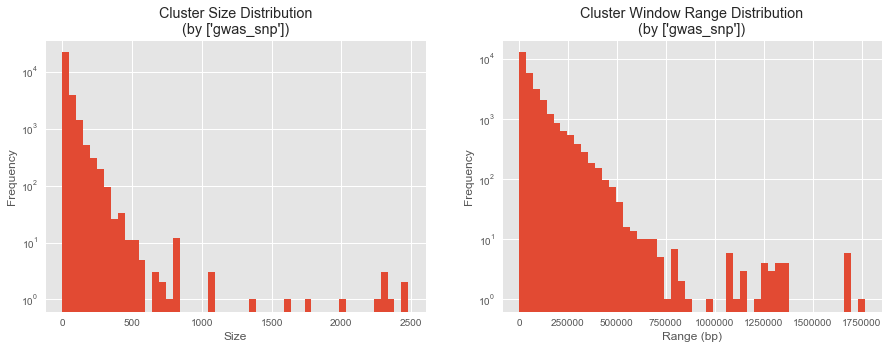

Clustering by ['gwas_snp', 'gene_id']
Number of clusters: 482395
Smallest 1;  Largest 2282
Narrowest 0;  Widest 1766206


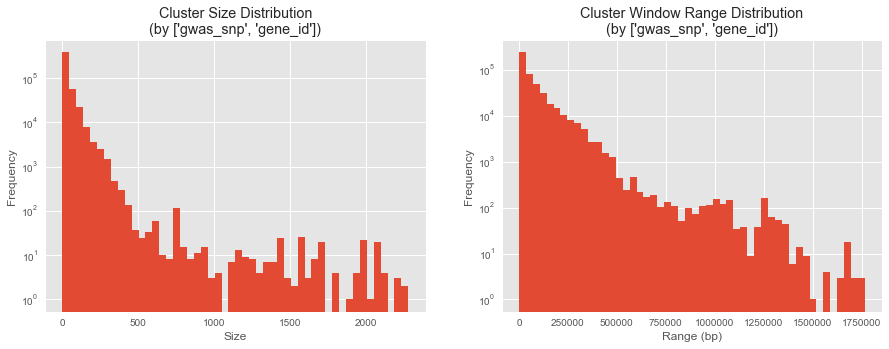

Clustering by ['gwas_snp', 'disease_efo_id']
Number of clusters: 42941
Smallest 1;  Largest 2479
Narrowest 0;  Widest 1691915


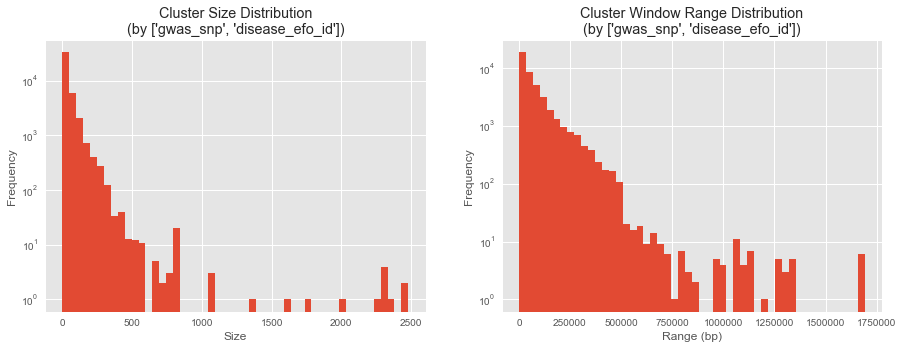

Clustering by ['gwas_snp', 'gene_id', 'disease_efo_id']
Number of clusters: 762410
Smallest 1;  Largest 2282
Narrowest 0;  Widest 1691915


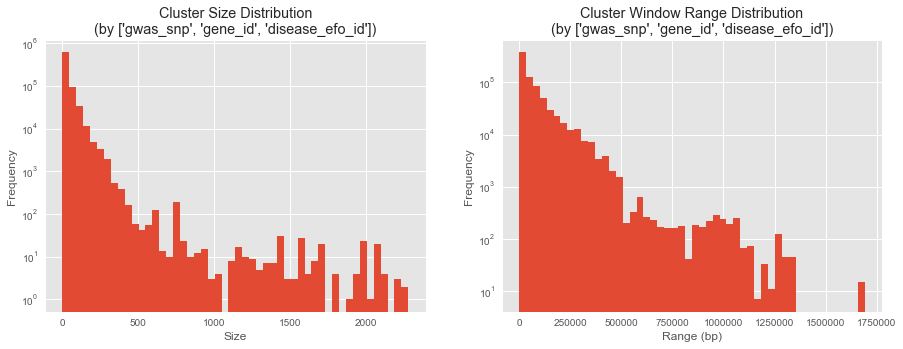

In [27]:
plot_cluster_scheme_summary(set_a)
plot_cluster_scheme_summary(set_b)
plot_cluster_scheme_summary(set_c)
plot_cluster_scheme_summary(set_d)

**Question**: Does the LD SNP chromosome always match the gene chromosome?

In [28]:
rows_different_chroms = pg[pg.chrom != pg.gene_chrom]
rows_different_chroms[['ld_snp_rsID', 'gene_symbol', 'chrom', 'gene_chrom']].groupby(['chrom', 'gene_chrom']).first()

ld_snp_rsID    gene_symbol
chrom gene_chrom                            
1     3            rs11165847          TFDP2
      6            rs34637442        C6orf89
      10          rs554523047          FANK1
      16          rs112103825          SF3B3
      17            rs3898317          GNGT2
      18            rs1167998         MYL12A
      1             rs2297797         EPS8L3
2     3             rs1902747         P2RY14
      6             rs3806523       HLA-DRB1
      8            rs13384342          MMP16
      9           rs535864343          DDX31
      10           rs17009149           ATE1
      11           rs72961173         OR10A5
      12           rs77120043        SLC6A12
      15           rs11126956       C15orf57
      16           rs10205592            GP2
      17           rs35517384          OR1G1
      18           rs12618567          SOGA2
      10           rs16845747          DHX32
      2             rs2303319           TBR1
      4            rs16845747         ZNF595
      X            rs16845747          VAMP7
3     1             rs6777467          RWDD3
      4             rs2143817          ABCG2
      6            rs11359982        C6orf89
      3           rs112646045          SMIM4
4     8            rs28374205         DENND3
      12          rs200215281  CTD-2140B24.4
      13           rs71200368          IFT88
      19            rs2883229         ZNF135
...                       ...            ...
16    19            rs2562154           MZF1
      16          rs112153252        SPATA2L
17    1            rs12951993          TMCO4
      7              rs745570           UNCX
      17           rs35901677           NAGS
      22           rs55766047        XPNPEP3
18    1             rs8094856         OR2AK2
      4            rs34693849         ZNF595
      9           rs199615461        RALGPS1
      19            rs7231585         ZNF562
      18           rs62101061  RP11-169F17.1
      X             rs8087659        SHROOM2
19    1             rs1615767          BCAR3
      4            rs12977629         ZNF595
      12            rs4514789         ZNF891
      13            rs2031061         CHAMP1
      19            rs7254221          ZNF90
20    4             rs6107130      LINC00955
      10          rs144209480          DHX32
      13            rs6011368          TMCO3
      14            rs3787100           WARS
      20            rs6059578         EIF2S2
21    1            rs13048019       ARHGAP30
      4           rs554144735         ZNF595
      11            rs8128474          OR4D9
      13           rs11700596         CHAMP1
      17            rs2823735            HN1
      21            rs6517527       C21orf49
22    9             rs8138638         GABBR2
      22             rs134892          NFAM1

[117 rows x 2 columns]

**Question**: How many unique `['ld_snp_rsID', 'gene_symbol']` pairs per `['chrom', 'gene_chrom']` pair?

In [29]:
rows_different_chroms[['ld_snp_rsID', 'gene_symbol', 'chrom', 'gene_chrom']].drop_duplicates().groupby(['chrom', 'gene_chrom']).size()

chrom  gene_chrom
1      3                2
       6                6
       10               2
       16               6
       17              17
       18               4
       1             2122
2      3               14
       6                3
       8                6
       9                2
       10              31
       11               2
       12               1
       15              11
       16               1
       17              20
       18               1
       10               5
       2             5007
       4                1
       X                1
3      1                2
       4               14
       6               52
       3             7203
4      8                3
       12               4
       13               2
       19               2
                     ... 
16     19               5
       16             932
17     1               12
       7                6
       17            3478
       22               4
18     1            

**Question**: How does POSTGAP score vary with distance (of LD SNP to gene TSS)?

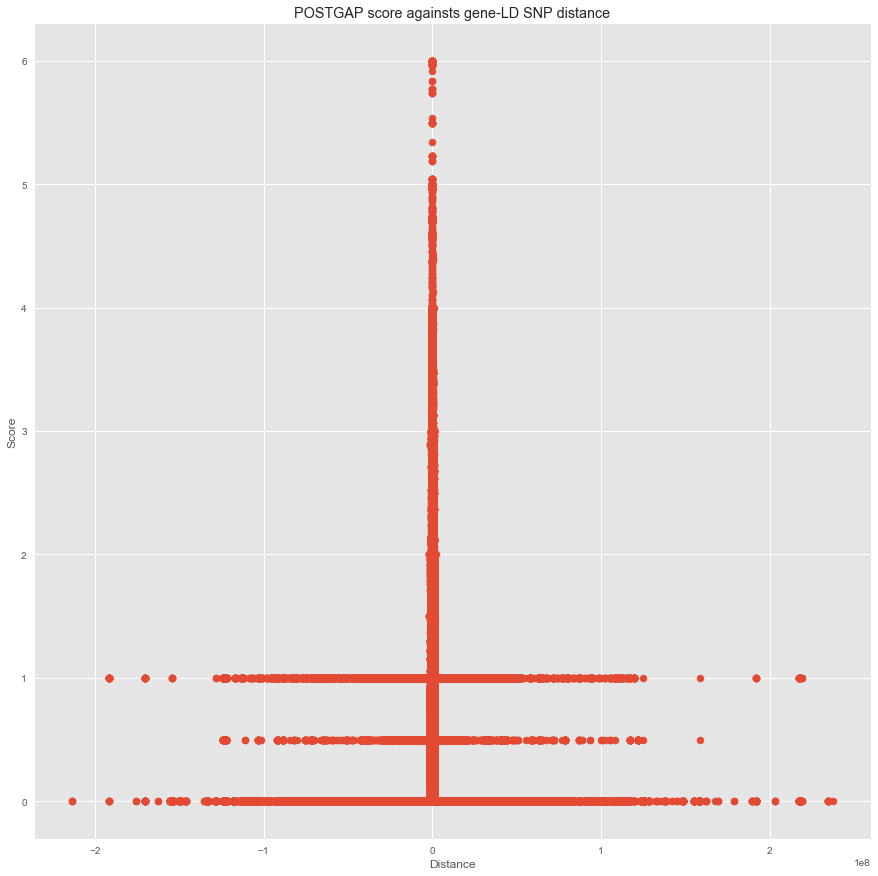

In [30]:
dists = pg.pos - pg.gene_tss
plt.figure(figsize=(15, 15))
plt.scatter(dists, pg.score)
plt.title('POSTGAP score againsts gene-LD SNP distance')
plt.ylabel('Score')
plt.xlabel('Distance')
plt.show()

**Question**: Which chromosomes are listed? Will the non-standard ones be a problem for visualisation?

In [31]:
pg.chrom.unique()

array([10, 12, 14,  9,  7, 15,  8, 11, 19,  4,  3, 16,  5,  6, 13,  1,  2,
       18, 20, 22, 17, 21])

**Question**: What are the distributions of the POSTGAP score constituent parts like?

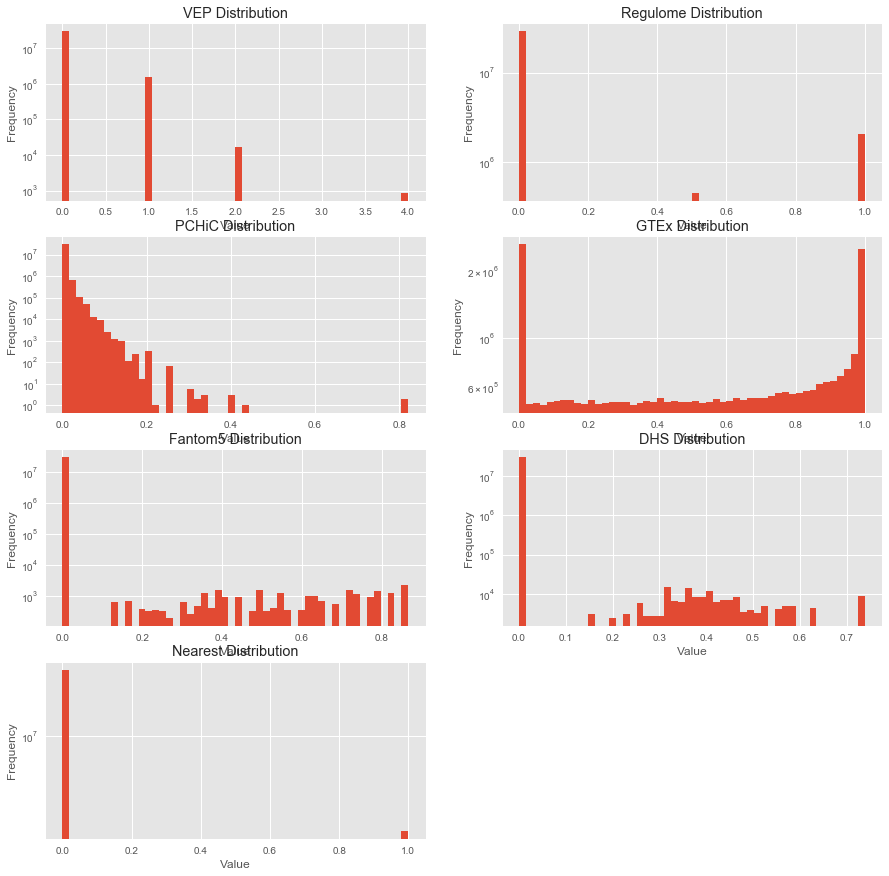

In [32]:
parts = ['VEP', 'Regulome', 'PCHiC', 'GTEx', 'Fantom5', 'DHS', 'Nearest']

# Note: this currently counts across rows for frequency, may also be interested in counts across unique (gene, LD SNP) pairs
plt.figure(figsize=(15, 15))
for (i, p) in enumerate(parts):
    plt.subplot(4, 2, i + 1)
    plt.hist(pg[p], bins=50, log=True)
    plt.title('{} Distribution'.format(p))
    plt.ylabel('Frequency')
    plt.xlabel('Value')

plt.show()

**Question**: For a given (gene, LD SNP) pair, are the score constituents always the same? (I would expect this on the assumption that POSTGAP score is gene-snp centric.)

In [33]:
combs = itertools.combinations(parts, 2)
pair = ['gene_id', 'ld_snp_rsID']
unique_counts_per_gene_snp = pg[[*pair, *parts]].groupby(pair).nunique()
unique_count_is_1_across_all_cols = unique_counts_per_gene_snp.apply(lambda x: x == 1).all(axis=1)
# Note: If the answer is yes to the above, would expect unique_count_is_1_across_all_cols to be always true.
# The following (gene, snp) pairs must have at least one constituent part that is multi-valued.
unique_count_is_1_across_all_cols[unique_count_is_1_across_all_cols == False]

gene_id          ld_snp_rsID
ENSG00000001167  rs35105472     False
ENSG00000002919  rs9900979      False
ENSG00000004975  rs2075230      False
ENSG00000005243  rs9900979      False
ENSG00000007047  rs72654473     False
ENSG00000007255  rs72654473     False
ENSG00000009950  rs34430945     False
ENSG00000010318  rs2710323      False
ENSG00000012660  rs144749723    False
                 rs6904083      False
ENSG00000035115  rs34848618     False
ENSG00000051341  rs11717893     False
ENSG00000053254  rs17125347     False
ENSG00000054116  rs3917937      False
ENSG00000054148  rs66923109     False
ENSG00000058335  rs7183818      False
ENSG00000061938  rs113635136    False
ENSG00000062485  rs56108400     False
ENSG00000065029  rs202166406    False
ENSG00000065135  rs12740374     False
                 rs660240       False
ENSG00000065357  rs3138142      False
                 rs56108400     False
ENSG00000065361  rs3138142      False
                 rs56108400     False
ENSG00000068976  rs49

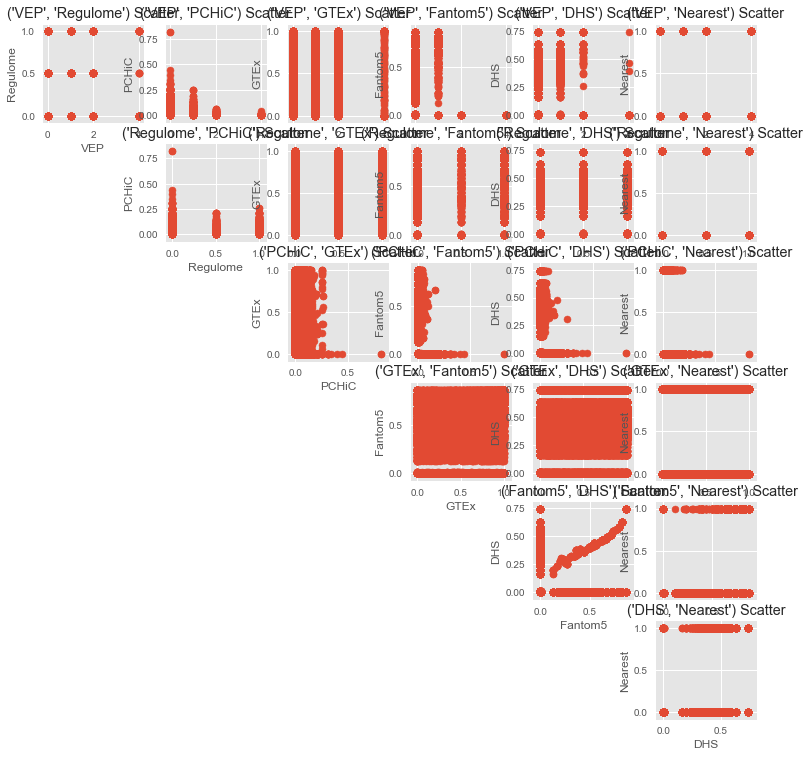

In [34]:
values_per_gene_snp = pg[[*pair, *parts]].groupby(pair).first()
combs = itertools.combinations(parts, 2)

plt.figure(figsize=(15, 15))
for (i, c) in enumerate(combs):
    plt.subplot(7, 7, (parts.index(c[0]) * 7) + parts.index(c[1]) + 1)
    plt.scatter(values_per_gene_snp[c[0]], values_per_gene_snp[c[1]])
    plt.title('{} Scatter'.format(c))
    plt.ylabel('{}'.format(c[1]))
    plt.xlabel('{}'.format(c[0]))

plt.show()

In [ ]:
# TODO: Investigate
#       * Distribution across chromosomes
#       * Distribution across 1Mbp windows (since this is some sort of cut-off in POSTGAP)
#       * Can we show a gene against ld snp co-occurrence matrix? What about gene against disease?
# .     * More thoughts...?